Using the Hermite-Simpson Method: 
$$
\bar{y} = \frac{1}{2}(y_i+y_{i+1}) + \frac{h_i}{8}(f_i-f_{i+1}) \\
\bar{f} = f(\bar{y},t_i+\frac{h_i}{2}) \\
y_{i+1} = y_i +\frac{h_i}{6}(f_i+4\bar{f} + f_{i+1})
$$

Parmis les équations, la deuxième, où les deux paramètres d'équation dynamique sont pas donné directement, est le plus difficile à réalisé en considérant l'interpolation de l'état et du temps

In [1]:
using JuMP
using Ipopt
#using COPSBenchmark
import Plots

In [2]:
function rocket_model_hersim(nh)
    h_0 = 1.0   #hauteur init
    v_0 = 0.0   #vitesse init
    m_0 = 1.0   #masse init
    g_0 = 1.0   #grativité init
    T_c = 3.5
    h_c = 500.0
    v_c = 620.0
    m_c = 0.6

    c = 0.5*sqrt(g_0 * h_0)
    m_f = m_c * m_0
    D_c = 0.5 * v_c * (m_0 / g_0)
    T_max = T_c * m_0 * g_0

    model = Model()

    @variables(model, begin
        1.0 <= h[i=0:nh,j=0:1],          (start=1.0)
        0.0 <= v[i=0:nh,j=0:1],          (start=i/nh*(1.0 - i/nh))
        m_f <= m[i=0:nh,j=0:1] <= m_0,   (start=(m_f - m_0)*(i/nh) + m_0)
        0.0 <= T[i=0:nh,j=0:1] <= T_max, (start=T_max/2.0)
        0.0 <= step,               (start=1/nh)
    end)

    @expressions(model, begin
        D[i=0:nh,j=0:1],  D_c*v[i,j]^2*exp(-h_c*(h[i,j] - h_0))/h_0
        g[i=0:nh,j=0:1],  g_0 * (h_0 / h[i,j])^2
        dh[i=0:nh,j=0:1], v[i,j]
        dv[i=0:nh,j=0:1], (T[i,j] - D[i,j] - m[i,j]*g[i,j]) / m[i,j]
        dm[i=0:nh,j=0:1], -T[i,j]/c
    end)

    @objective(model, Max, h[nh,0])

    #Hermite-Simpson Method
    @constraints(model,begin
        def_ref_h[i=1:nh-1], h[i,1] == 0.5 * (h[i,0] + h[i+1,0]) + 0.125 * step * (dh[i,0] - dh[i+1,0])
        def_ref_v[i=1:nh-1], v[i,1] == 0.5 * (v[i,0] + v[i+1,0]) + 0.125 * step * (dv[i,0] - dv[i+1,0])
        def_ref_m[i=1:nh-1], m[i,1] == 0.5 * (m[i,0] + m[i+1,0]) + 0.125 * step * (dm[i,0] - dm[i+1,0])

        con_dh[i=1:nh], h[i,0] == h[i-1,0] + 1/6 * step * (dh[i-1,0] + dh[i,0] + 4 * dh[i-1,1])
        con_dv[i=1:nh], v[i,0] == v[i-1,0] + 1/6 * step * (dv[i-1,0] + dv[i,0] + 4 * dv[i-1,1])
        con_dm[i=1:nh], m[i,0] == m[i-1,0] + 1/6 * step * (dm[i-1,0] + dm[i,0] + 4 * dm[i-1,1])
    end)
    
    #Boundary constraints
    @constraints(model, begin
        h_ic, h[0,0] == h_0
        v_ic, v[0,0] == v_0
        m_ic, m[0,0] == m_0
        m_fc, m[nh,0] == m_f

        h_ic_1, h[0,1] == h_0
        v_ic_1, v[0,1] == v_0
        m_ic_1, m[0,1] == m_0
    end)

    return model
end

function Generate_thrust_hersim(nhs=nhs)
    P = Plots.plot(xlabel="Temps", ylabel="Value")
    Thrusts = [[[] for i in range(1,length(nhs))] for j in range(1,2)]
    for i in range(1,length(nhs))
        nh = nhs[i]
        model = rocket_model_hersim(nh)
        JuMP.set_optimizer(model, Ipopt.Optimizer)
        JuMP.optimize!(model)
        T_value = value.(model[:T]);
        T_Array = Array(T_value[:,0]);
        T_Array_dua = Array(T_value[:,1]);
        Thrusts[1][i] = T_Array
        Thrusts[2][i] = T_Array_dua
        Plots.plot!(LinRange(0,0.2,length(T_Array)),T_Array,label="T values for nh = $nh")
    end
    Plots.display(P)
    return Thrusts
end

Generate_thrust_hersim (generic function with 2 methods)

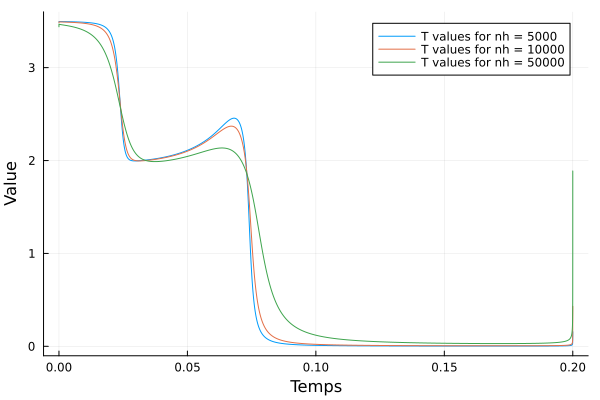


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   264983
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   729951

Total number of variables............................:    40009
                     variables with only lower bounds:    20005
                variables with lower and upper bounds:    20004
                     variables with only upper bounds:        0
Total number of equality constraints.................:    30004
Total number of inequality c

2-element Vector{Vector{Vector{Any}}}:
 [[3.4925109683901003, 3.496251913332222, 3.4962283777615655, 3.4962097740089684, 3.496192342470416, 3.496175584343867, 3.4961592468038076, 3.4961431848151627, 3.4961273078014163, 3.4961115555413267  …  0.013463482066591514, 0.014229793059936865, 0.015155010483066451, 0.016302777558138165, 0.01777923585803449, 0.019778124239182886, 0.022702422621791563, 0.02758425259106545, 0.03844177526335843, 0.15705921804166914], [3.4853774791629593, 3.4926695165238097, 3.492627713751939, 3.4925980946042436, 3.4925721350133005, 3.4925484443564954, 3.4925263133519917, 3.492505320416095, 3.4924851912772885, 3.4924657367186946  …  0.037434689771013475, 0.039605194011879105, 0.0422257499252544, 0.04547678246527451, 0.049659373133495076, 0.0553235639642383, 0.06361506577620363, 0.07747575345011608, 0.10839016076549969, 0.4305739561438305], [3.4396405293524714, 3.469460208846449, 3.4690818079080805, 3.468863989441339, 3.4686952807634395, 3.4685545754866656, 3.4684320

In [3]:
Thrusts_hersim = Generate_thrust_hersim([5000,10000,50000])

In [6]:
function rocket_model(nh)
    h_0 = 1.0   #hauteur init
    v_0 = 0.0   #vitesse init
    m_0 = 1.0   #masse init
    g_0 = 1.0   #grativité init
    T_c = 3.5
    h_c = 500.0
    v_c = 620.0
    m_c = 0.6

    c = 0.5*sqrt(g_0 * h_0)
    m_f = m_c * m_0
    D_c = 0.5 * v_c * (m_0 / g_0)
    T_max = T_c * m_0 * g_0

    model = Model()

    @variables(model, begin
        1.0 <= h[i=0:nh],          (start=1.0)
        0.0 <= v[i=0:nh],          (start=i/nh*(1.0 - i/nh))
        m_f <= m[i=0:nh] <= m_0,   (start=(m_f - m_0)*(i/nh) + m_0)
        0.0 <= T[i=0:nh] <= T_max, (start=T_max/2.0)
        0.0 <= step,               (start=1/nh)
    end)

    @expressions(model, begin
        D[i=0:nh],  D_c*v[i]^2*exp(-h_c*(h[i] - h_0))/h_0
        g[i=0:nh],  g_0 * (h_0 / h[i])^2
        dh[i=0:nh], v[i]
        dv[i=0:nh], (T[i] - D[i] - m[i]*g[i]) / m[i]
        dm[i=0:nh], -T[i]/c
    end)

    @objective(model, Max, h[nh])

    # Dynamics
    @constraints(model, begin
        con_dh[i=1:nh], h[i] == h[i-1] + 0.5 * step * (dh[i] + dh[i-1])
        con_dv[i=1:nh], v[i] == v[i-1] + 0.5 * step * (dv[i] + dv[i-1])
        con_dm[i=1:nh], m[i] == m[i-1] + 0.5 * step * (dm[i] + dm[i-1])
    end)
    # Boundary constraints
    @constraints(model, begin
        h_ic, h[0] == h_0
        v_ic, v[0] == v_0
        m_ic, m[0] == m_0
        m_fc, m[nh] == m_f
    end)

    return model
end

function Generate_thrust(nhs=nhs)
    Thrusts = [[] for i in range(1,length(nhs))]
    P = Plots.plot(xlabel="Temps", ylabel="Value")
    for i in range(1,length(nhs))
        nh = nhs[i]
        model = rocket_model(nh)
        JuMP.set_optimizer(model, Ipopt.Optimizer)
        JuMP.optimize!(model)
        T_value = value.(model[:T]);
        T_Array = Array(T_value);
        Thrusts[i] = T_Array
        Plots.plot!(LinRange(0,0.2,length(T_Array)),T_Array,label="T values for nh = $nh")
    end
    Plots.display(P)
    return Thrusts
end

Generate_thrust (generic function with 2 methods)

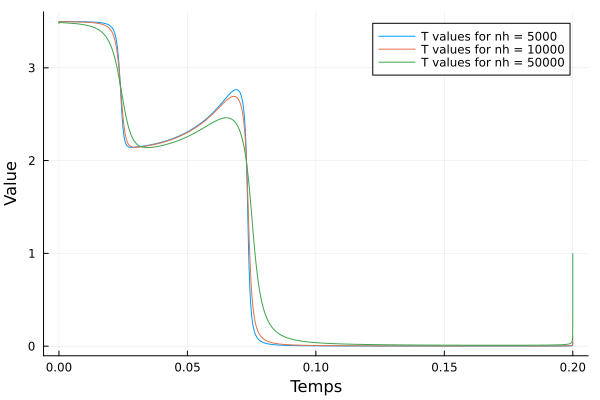

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   105004
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   245000

Total number of variables............................:    20005
                     variables with only lower bounds:    10003
                variables with lower and upper bounds:    10002
                     variables with only upper bounds:        0
Total number of equality constraints.................:    15004
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.50e-02 1.91e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

3-element Vector{Vector{Any}}:
 [3.4974846831122663, 3.4987393782632714, 3.498733429286303, 3.4987279513157095, 3.498722673190024, 3.498717501602579, 3.4987123910502906, 3.4987073158273314, 3.498702260013552, 3.498697213071389  …  0.004488809744435522, 0.004745174251486661, 0.005054928220593717, 0.005439627142006328, 0.005935423318112873, 0.006608935047647548, 0.007601262564636282, 0.009289577668717122, 0.013367255761408355, 0.036019415001165025]
 [3.495028391425834, 3.4975079635543564, 3.497498946072467, 3.4974915137366547, 3.4974847575555406, 3.4974784018032903, 3.497472315426661, 3.4974664225752417, 3.4974606745000187, 3.497455037792555  …  0.012486325428498151, 0.013213036584976303, 0.014091133216246403, 0.015181800119409894, 0.01658770532032792, 0.018498167885909814, 0.021314602428641385, 0.026112095946130256, 0.037743978138248015, 0.1011836193959329]
 [3.4774550442730012, 3.488641788171799, 3.488564258524109, 3.488516259074167, 3.4884794993657366, 3.488448833977289, 3.48842205015

In [5]:
Thrusts_norm = Generate_thrust([5000,10000,50000])

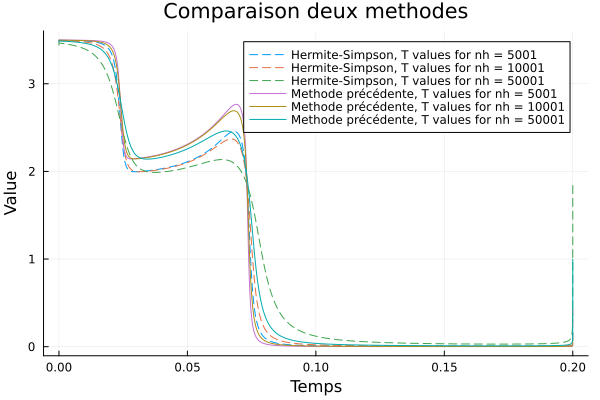

In [9]:
p = Plots.plot(xlabel="Temps", ylabel="Value",title = "Comparaison deux methodes")
for Thrust_hersim in Thrusts_hersim[1]
    Plots.plot!(LinRange(0,0.2,length(Thrust_hersim)),Thrust_hersim,linestyle = :dash,label="Hermite-Simpson, T values for nh = $(length(Thrust_hersim))")
end
for Thrust in Thrusts_norm
    Plots.plot!(LinRange(0,0.2,length(Thrust)),Thrust,label="Methode précédente, T values for nh = $(length(Thrust))")
end
Plots.display(p)